# Citywide Cellular Traffic Prediction Based on Densely Connected Convolutional Neural Networks 
## —— Dataset Analyse and Preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #空间三维画图
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Dataset

Dataset:
the telecommunication activity in the city of Milan and in the Province of Trentino.
* paper: A multi-source dataset of urban life in the city of Milan and the Province of Trentino
* src: https://doi.org/10.7910/DVN/EGZHFV
* Format: 
    - Square id
    - Time Interval
    - Country code
    - SMS-in activity
    - SMS-out activity
    - Call-in activity
    - Call-out activity
    - Internet traffic activity

In [2]:
data = []
for i in range(4, 4+1):
    if i == 4:
        data = pd.read_csv("sms-call-internet-mi-2013-11-" + str(i).rjust(2, '0') + ".txt",header=None, sep = '\t')
    else:
        data = pd.concat([data, pd.read_csv("sms-call-internet-mi-2013-11-" + str(i).rjust(2, '0') + ".txt",header=None, sep = '\t')])
    
data.columns = ['SquareID', 'Time', 'CountryCode', 'SMSIn', 'SMSOut', 'CallIn', 'CallOut', 'Internet']
data = data.fillna(0)
valueIndex = ['SMSIn', 'SMSOut', 'CallIn', 'CallOut', 'Internet']

print(data)

         SquareID           Time  CountryCode     SMSIn    SMSOut    CallIn  \
0               1  1383519600000            0  0.108039  0.000000  0.000000   
1               1  1383519600000           39  0.026137  0.030875  0.026137   
2               1  1383520200000           39  0.187075  0.106876  0.027300   
3               1  1383520800000           39  0.027925  0.027925  0.001787   
4               1  1383521400000           39  0.190564  0.106876  0.000000   
...           ...            ...          ...       ...       ...       ...   
5639483      9999  1383604200000           39  0.357121  1.338923  0.237047   
5639484      9999  1383604800000            0  0.085995  0.000000  0.000000   
5639485      9999  1383604800000           39  0.332386  1.383220  0.092566   
5639486      9999  1383605400000            0  0.014708  0.000000  0.000000   
5639487      9999  1383605400000           39  0.288963  0.288963  0.237047   

          CallOut   Internet  
0        0.000000   

## Dataset Analyse -- Spatial & Temporal Features

Spatial Distribution

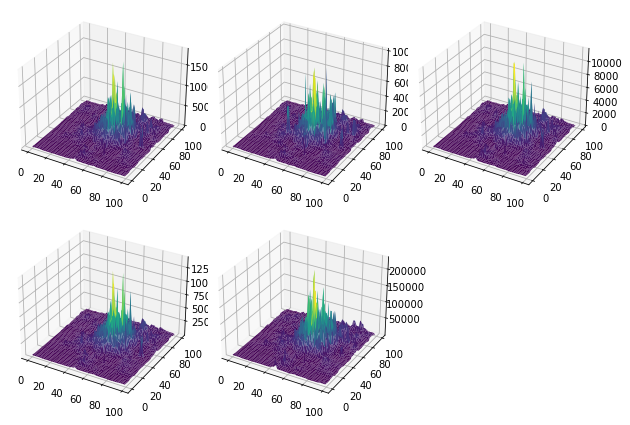

In [3]:
data1 = data.groupby(['SquareID'])
fig = plt.figure(figsize = (8.5, 6))

for i in range(np.size(valueIndex)):
    spatialDistribution = data1[valueIndex[i]].sum().sort_index()
    spatialDistribution = np.array(spatialDistribution).reshape(100,100)

    [X, Y] = np.meshgrid(np.arange(np.size(spatialDistribution,1)), np.arange(np.size(spatialDistribution,0))) 
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.plot_surface(X, Y, spatialDistribution,cmap='viridis', edgecolor='none')
    
fig.tight_layout()

Temporal Distribution

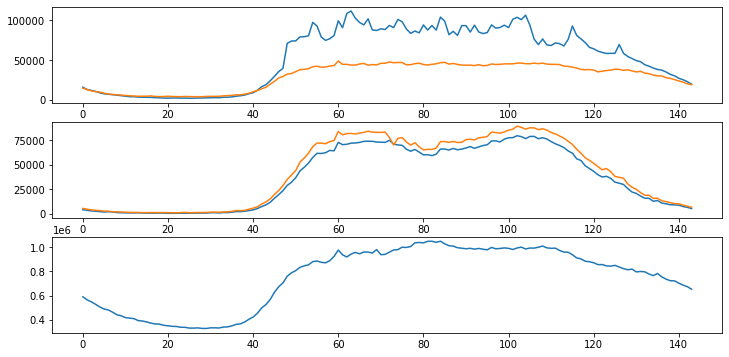

In [5]:
data1 = data.groupby(['Time'])
fig, ax = plt.subplots(3, 1, figsize = (12, 6))

for i in range(np.size(valueIndex)):
    temporalDistribution = data1[valueIndex[i]].sum().sort_index()
    temporalDistribution = np.array(temporalDistribution)

    if(i<2):
        ax[0].plot(temporalDistribution)
    elif(i<4):
        ax[1].plot(temporalDistribution)
    else:
        ax[2].plot(temporalDistribution)

Spatial & Temporal Correlation

## Dataset Preprocess